# Solving MAXCUT Using QAOA in `qiskit`

Max-Cut is an NP-complete problem, with applications in clustering, network science, and statistical physics. To grasp how practical applications are mapped into given Max-Cut instances, consider a system of many people that can interact and influence each other. Individuals can be represented by vertices of a graph, and their interactions seen as pairwise connections between vertices of the graph, or edges. With this representation in mind, it is easy to model typical marketing problems. For example, suppose that it is assumed that individuals will influence each other’s buying decisions, and knowledge is given about how strong they will influence each other. The influence can be modeled by weights assigned on each edge of the graph. It is possible then to predict the outcome of a marketing strategy in which products are offered for free to some individuals, and then ask which is the optimal subset of individuals that should get the free products, in order to maximize revenues.



Consider an $n$-node undirected graph $G = (V, E)$ where $|V| = n$ with edge weights $w_{ij} \geq 0$, $w_{ij} = w_{ji}$ for $(i, j) \in E$. A cut is defined as a partition of the original set $V$ into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, crossing the cut.

In [40]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import NELDER_MEAD
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

from qaoa_vrp.parallel.optimize_qaoa import run_qaoa_parallel, run_qaoa_parallel_control_max_restarts
import seaborn as sns
import pandas as pd

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
import pathos.pools as pp

from qaoa_vrp.plot.feasibility_graph import (
    plot_feasibility_results,
    generate_feasibility_results,
)

sns.set_theme()


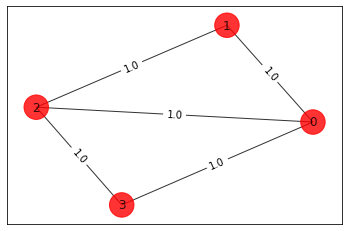

In [2]:
# Generating a graph of 4 nodes

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [3]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


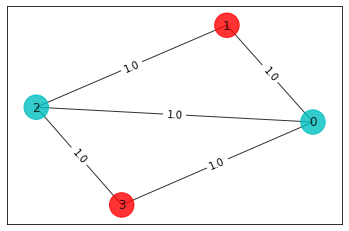

In [4]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

In [5]:
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -2.5
Ising Hamiltonian:
IIZZ	(0.5+0j)
IZIZ	(0.5+0j)
IZZI	(0.5+0j)
ZIIZ	(0.5+0j)
ZZII	(0.5+0j)



/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/optimization/applications/ising/max_cut.py:54: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return WeightedPauliOperator(paulis=pauli_list), shift


In [6]:
# mapping Ising Hamiltonian to Quadratic Program
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;

minimize
 [ - 3 x_0^2 + 2 x_0*x_1 + 2 x_0*x_2 + 2 x_0*x_3 - 2 x_1^2 + 2 x_1*x_2
 - 3 x_2^2 + 2 x_2*x_3 - 2 x_3^2 ];
 
subject to {

}


In [7]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: -4.0
optimal value: [1. 0. 1. 0.]
status: SUCCESS


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.eigen_solvers',


energy: -1.5
max-cut objective: -4.0
solution: [0 1 0 1]
solution objective: 4.0


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:215: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  unique, counts = np.unique(aqua_globals.random.choice(list(deterministic_counts.keys()),


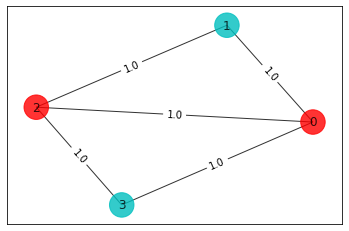

In [8]:
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

In [11]:
p_max=5
max_restarts=3
optimizers = [
        [
            NELDER_MEAD(
                disp=True, 
                adaptive=True, 
                tol=0.1,
                maxfev=10000
                ),
            max_restarts,
            qubitOp, # Operator
            p+1, #Num layers
            False, # Mlflow tracking
        ] for p in range(p_max)
    ]

/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',


In [19]:
results = [run_qaoa_parallel_control_max_restarts(optimizer) for optimizer in optimizers]

 Running Optimizer: NELDER_MEAD in parallel with 1 layers and 3 restarts
Starting restart n=1 for layer(s) 1


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Optimization terminated successfully.
         Current function value: -0.736328
         Iterations: 31
         Function evaluations: 72
Starting restart n=2 for layer(s) 1
Optimization terminated successfully.
         Current function value: -0.737305
         Iterations: 31
         Function evaluations: 67
Starting restart n=3 for layer(s) 1
Optimization terminated successfully.
         Current function value: -0.736328
         Iterations: 29
         Function evaluations: 72
 Ending run for  Optimizer: NELDER_MEAD in parallel
 Running Optimizer: NELDER_MEAD in parallel with 2 layers and 3 restarts
Starting restart n=1 for layer(s) 2
Optimization terminated successfully.
         Current function value: -0.669922
         Iterations: 92
         Function evaluations: 236
Starting restart n=2 for layer(s) 2
Optimization terminated successfully.
         Current function value: -0.846680
         Iterations: 126
         Function evaluations: 285
Starting restart n=3 for layer(s)

In [20]:
d_results = []
for res in results:
    d_res = pd.DataFrame(
        list(zip(res['converge_cnts'], res['converge_vals'])),
        columns=['n_eval', 'value'],
    )
    d_res["optimizer"] = res["optimizer"]
    d_res["layer"] = res["layers"]
    d_results.append(d_res)
d_results = pd.concat(d_results)
d_results['total_evals'] = d_results.groupby('layer').cumcount() + 1

Make the plots

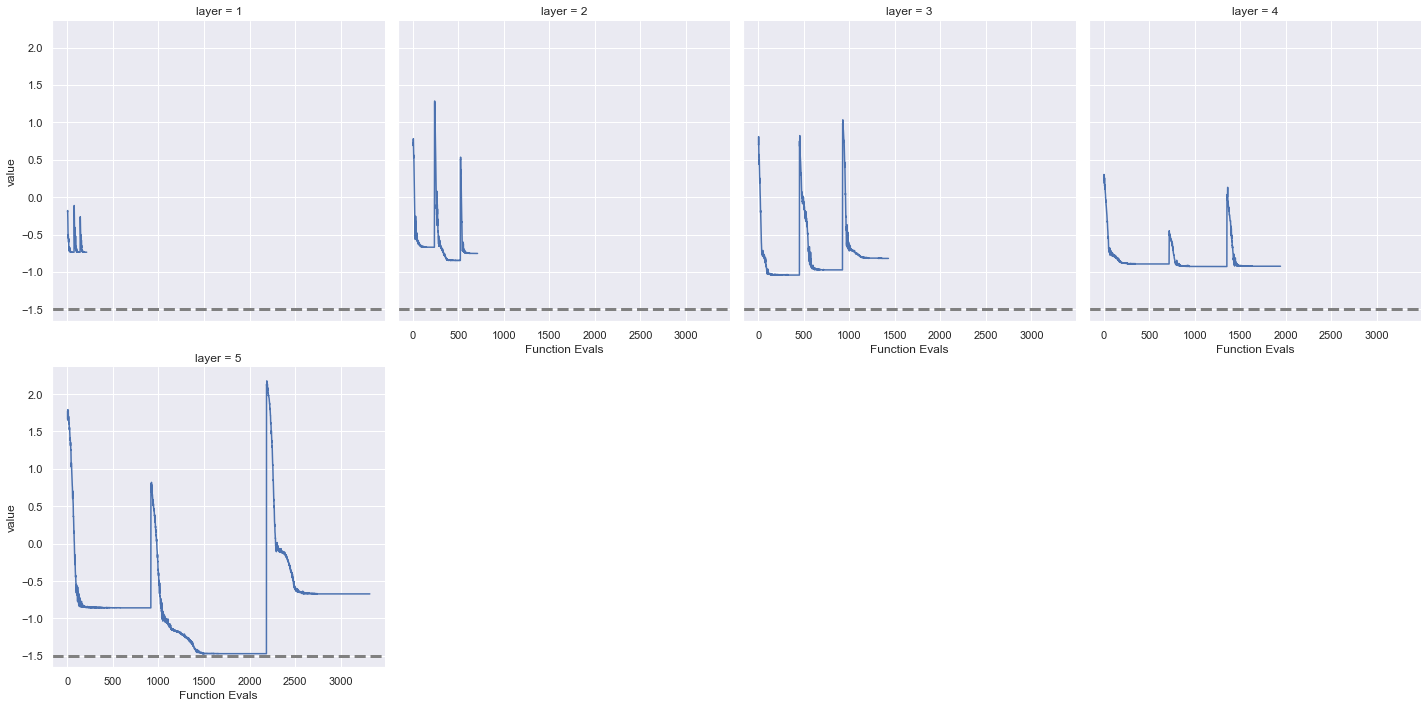

In [63]:
g = sns.relplot(data=d_results, x="total_evals", y="value", col="layer", kind="line", col_wrap=4)
axes = g.axes.flatten()
for ax in axes:
            ax.axhline(
                result.eigenvalue.real, ls='--', linewidth=3, color='grey'
            )
            ax.set_xlabel("Function Evals")

In [111]:
d_sols = []
for res in results:
    d_me_res = pd.DataFrame([res['min_energy_state']]).melt(var_name='state')
    d_me_res['layers'] = res['layers']
    d_sols.append(d_me_res)
d_sols = pd.concat(d_sols)
# Add solution
def is_solution(state):
    if state == '1010' or state == '0101':
        return 'Valid'
    else:
        return 'Invalid'
d_sols['']

,state,value,layers
0,0000,8,1
1,1000,8,1
2,0111,17,1
3,1111,10,1
4,1101,11,1
...,...,...,...
3,1010,497,5
4,0111,1,5
5,0011,8,5
6,0110,12,5


TypeError: set_ticks() got an unexpected keyword argument 'rot'

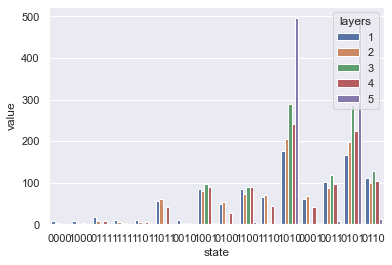

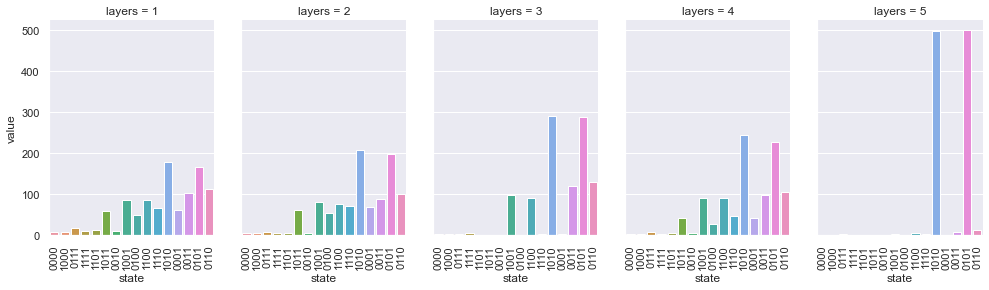

In [100]:
g = sns.catplot(x="state", y="value", col="layers", data=d_sols, kind="bar", height=4, aspect=.7)
g.set_xticklabels(rotation=90)